# Climate Solution Notebook

In [2]:
# Denpendencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta

# ignore version warning
from warnings import filterwarnings
filterwarnings('ignore')

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_, or_

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date_str = (
    session.query(Measurements.date)
    # .order_by(Measurements.date)
    .order_by(Measurements.date.desc())
    .limit(1)
    # Use the `.scalar()` method to execute the query and get a single result. This will return a single value from the first column of the query.
    .scalar()
)
most_recent_date = dt.strptime(most_recent_date_str, "%Y-%m-%d")
print(most_recent_date)

2017-08-23 00:00:00


<Figure size 1200x800 with 0 Axes>

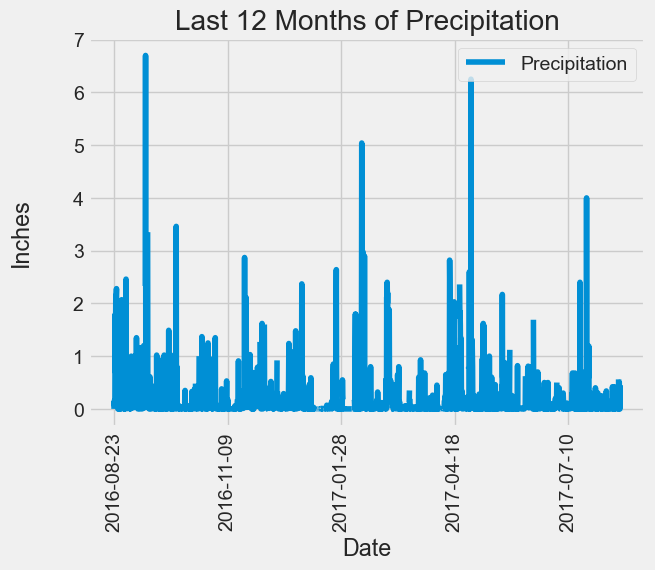

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in data set.
previous_date = (
    (most_recent_date - timedelta(days=365))   # Calculate the date
    .strftime('%Y-%m-%d')  # Format
)
# previous_date
# Perform a query to retrieve the data and precipitation scores
prcp_data = (
    session.query(Measurements.date, Measurements.prcp)
    .filter(and_(Measurements.date >= previous_date,
                 Measurements.date <= most_recent_date))
    .order_by(Measurements.date)
    .all()
)
## Display and review
# print(prcp_data)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = (
    pd.DataFrame(prcp_data, columns=['date', 'precipitation'])
    .sort_values(by='date')  # Sort the dataframe by date
    .set_index('date')
)
# Display and review
# prcp_df

plt.figure(figsize=(12, 8))
ax = prcp_df.plot(y='precipitation', rot=90)

# Set y-axis label with specific position
ax.set_ylabel('Inches', labelpad=20)
ax.yaxis.set_label_coords(-0.1, 0.5)

plt.xlabel('Date')
plt.title('Last 12 Months of Precipitation')
plt.legend(['Precipitation'], loc='upper right')
plt.show()

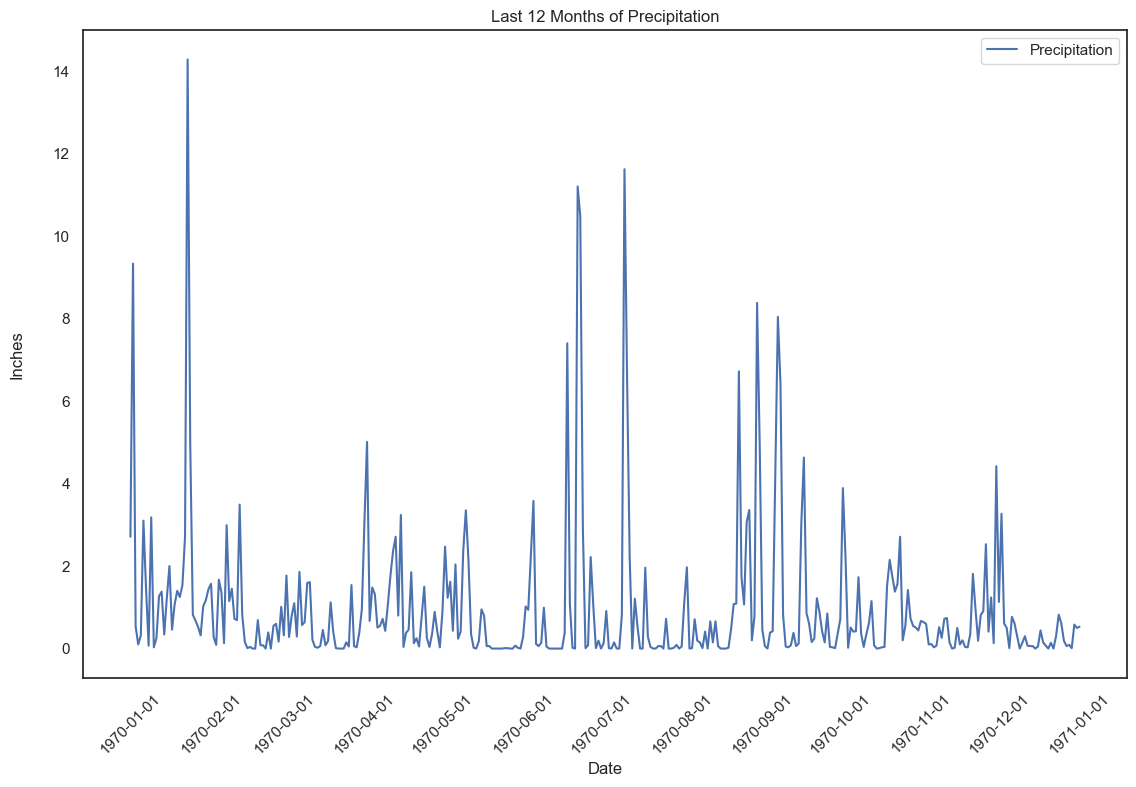

In [18]:
import matplotlib.dates as mdates

# Handle duplicate dates by aggregating the precipitation values
prcp_df_aggregated = prcp_df.groupby('date').agg({'precipitation': 'sum'}).reset_index()

# Ensure seaborn uses a white background
sns.set(style="white")

# Plot the line chart
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='date', y='precipitation', data=prcp_df_aggregated)

# Set y-axis label with specific position
ax.set_ylabel('Inches', labelpad=20)

# Formatting the x-axis
ax.set_xlabel('Date')
ax.set_title('Last 12 Months of Precipitation')
ax.legend(['Precipitation'], loc='upper right')

# Rotate the x-axis date labels
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Set the background color to white
ax.set_facecolor('white')

plt.show()

#### Observation and Analysis

This chart shows the precipitation data for a 12-month period from August 23, 2016, to August 23, 2017.

- High precipitation events: There were several particularly high precipitation events during this time, such as at the end of August 2016, the end of January 2017, and mid-April 2017.
- Low precipitation periods: For most of the time frame, the precipitation levels were low, typically ranging between 0 to 1 inch.

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
cnt_stations = (
    session.query(Measurements.station)
    .distinct()
    .count()
)

print(cnt_stations)

9


In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
cnt_active_station = (
    session.query(Measurements.station, func.count(Measurements.station))
    .group_by(Measurements.station)
    .order_by(func.count(Measurements.station).desc())
    .all()
)
cnt_active_station   # List the stations and observation counts in descending order

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the mos most_active_station
most_active_station = cnt_active_station[0][0]

selected_station_temp = (
    session.query(
        func.min(Measurements.tobs).label('Lowest Temperature'),
        func.max(Measurements.tobs).label('highest temperature'),
        func.avg(Measurements.tobs).label('Average Temperature')
    )
    .filter(Measurements.station == most_active_station)
    .all()
)

selected_station_temp

[(54.0, 85.0, 71.66378066378067)]

<Figure size 1200x1000 with 0 Axes>

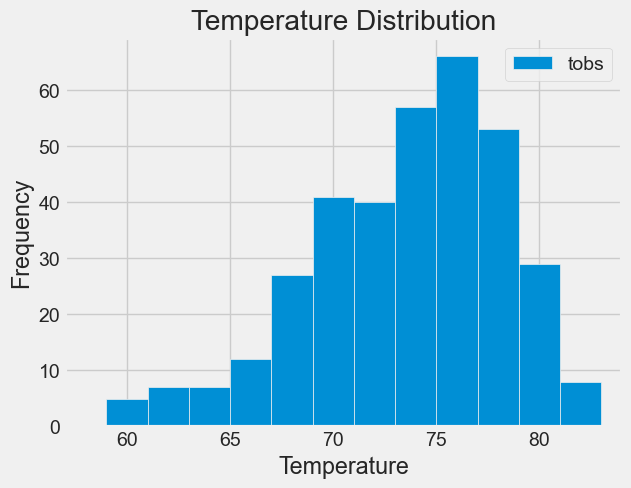

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the data and temperature data in last 12 months
temp_data = (
    session.query(Measurements.tobs)
    .filter(and_(
        Measurements.station == most_active_station,
        Measurements.date.between(previous_date, most_recent_date) 
    ))
    .all()
)

temp_df = pd.DataFrame(temp_data)

# Plot the histogram 
plt.figure(figsize=(12, 10))
temp_df.plot(kind='hist', y='tobs', bins=12, rwidth=1)
# sns.histplot(data=temp_df['tobs'], bins=12, kde=False,label='tobs') 
# Define the x-axis 
plt.xlim(57, 84)

# Title and Labels
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.legend(loc='best')
plt.show()


#### Observation and Analysis

This chart shows the frequency distribution histogram of temperature data (TOBS) measured over a certain period.

- Overall trend: It is evident how the frequency distribution varies across different temperature ranges.
- High-frequency temperature range: The measurements between 70°F and 75°F are the most frequent, indicating that this is the most common temperature range in the dataset.
- Low-frequency temperature range: Measurements around 60°F to 65°F and around 80°F are relatively sparse.
- Data concentration: Most of the temperature data is concentrated between 70°F and 75°F, showing a clear trend of data concentration.

In [106]:
# Close Session
session.close()